#### Q.1) Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import copy
import datetime

In [2]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


#### Q.2) Load the given data

In [3]:
df=pd.read_csv('/home/agcl/Downloads/Solar_Energy_Production - Solar_Energy_Production.csv')

In [4]:
df

,name,id,address,date,kWh,public_url,installationDate,uid
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 8:00:00 AM,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 9:00:00 AM,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 10:00:00 AM,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 11:00:00 AM,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 12:00:00 PM,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00
...,...,...,...,...,...,...,...,...
258418,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2023/03/12 3:00:00 PM,201.285,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502023-03-12 15:00:00
258419,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2023/03/12 4:00:00 PM,162.582,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502023-03-12 16:00:00
258420,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2023/03/12 5:00:00 PM,107.060,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502023-03-12 17:00:00
258421,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2023/03/12 6:00:00 PM,43.074,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502023-03-12 18:00:00


In [5]:
print(df.shape[0])

258423


In [6]:
df=df.drop('id',axis=1)
df=df.drop('address',axis=1)
df=df.drop('public_url',axis=1)
df=df.drop('uid',axis=1)


In [7]:
# Convert the 'Datetime' column to a datetime data type
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

# Sort the DataFrame by the 'Datetime' column in ascending order
df = df.sort_values('date')

# Set the 'Datetime' column as the index of the DataFrame
df.set_index('date', inplace=True)

# Plot the time-series data of the 'PJMW_MW' column
#df['PJMW_MW'].plot(c='g', figsize=(5, 3))
df

,name,kWh,installationDate
date,,,
2015-09-01 02:30:00,Southland Leisure Centre,27.805,2015/09/01
2015-09-01 03:30:00,Southland Leisure Centre,30.559,2015/09/01
2015-09-01 04:30:00,Southland Leisure Centre,23.613,2015/09/01
2015-09-01 05:30:00,Southland Leisure Centre,15.257,2015/09/01
2015-09-01 06:30:00,Southland Leisure Centre,7.896,2015/09/01
...,...,...,...
2023-03-16 12:00:00,Whitehorn Multi-Service Centre,177.344,2016/12/13
2023-03-16 12:00:00,Calgary Fire Hall Headquarters,8.383,2016/11/07
2023-03-16 12:00:00,Southland Leisure Centre,0.051,2015/09/01


In [8]:
inst=df['installationDate']
df=df.drop('installationDate',axis=1)
inst=pd.Series(inst)
inst

date
2015-09-01 02:30:00    2015/09/01
2015-09-01 03:30:00    2015/09/01
2015-09-01 04:30:00    2015/09/01
2015-09-01 05:30:00    2015/09/01
2015-09-01 06:30:00    2015/09/01
                          ...    
2023-03-16 12:00:00    2016/12/13
2023-03-16 12:00:00    2016/11/07
2023-03-16 12:00:00    2015/09/01
2023-03-16 12:00:00    2016/11/21
2023-03-16 12:00:00    2017/10/23
Name: installationDate, Length: 258423, dtype: object

In [9]:
inst= inst.str.split('/', expand=True)
inst.columns = ['yy','mm','dd']
inst= inst.astype(int)
inst

,yy,mm,dd
date,,,
2015-09-01 02:30:00,2015,9,1
2015-09-01 03:30:00,2015,9,1
2015-09-01 04:30:00,2015,9,1
2015-09-01 05:30:00,2015,9,1
2015-09-01 06:30:00,2015,9,1
...,...,...,...
2023-03-16 12:00:00,2016,12,13
2023-03-16 12:00:00,2016,11,7
2023-03-16 12:00:00,2015,9,1


In [10]:
'''Here, I converted the date and time details to datetime object and various features are created using the
details of hour,week of year,etc.'''
df['hour']=df.index.hour
#df['date']=df.index.date
#df['year']=df.index.year
df['month']=df.index.month
df['quarter']=df.index.quarter
df['day']=df.index.day
df['day_of_week']=df.index.day_name()
#df['second']=df.index.second
df['week_of_year']=df.index.week

/tmp/ipykernel_5249/4154217927.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year']=df.index.week


In [11]:
df

,name,kWh,hour,month,quarter,day,day_of_week,week_of_year
date,,,,,,,,
2015-09-01 02:30:00,Southland Leisure Centre,27.805,2,9,3,1,Tuesday,36
2015-09-01 03:30:00,Southland Leisure Centre,30.559,3,9,3,1,Tuesday,36
2015-09-01 04:30:00,Southland Leisure Centre,23.613,4,9,3,1,Tuesday,36
2015-09-01 05:30:00,Southland Leisure Centre,15.257,5,9,3,1,Tuesday,36
2015-09-01 06:30:00,Southland Leisure Centre,7.896,6,9,3,1,Tuesday,36
...,...,...,...,...,...,...,...,...
2023-03-16 12:00:00,Whitehorn Multi-Service Centre,177.344,12,3,1,16,Thursday,11
2023-03-16 12:00:00,Calgary Fire Hall Headquarters,8.383,12,3,1,16,Thursday,11
2023-03-16 12:00:00,Southland Leisure Centre,0.051,12,3,1,16,Thursday,11


In [12]:
'''This function is used to extract periodicity of the various features of the data'''
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs)


In [13]:
df = generate_cyclical_features(df, 'hour', 24, 0)
df = generate_cyclical_features(df, 'quarter',4, 1)
df = generate_cyclical_features(df, 'month', 12, 1)
df = generate_cyclical_features(df, 'week_of_year', 52, 0)

df

,name,kWh,hour,month,quarter,day,day_of_week,week_of_year,sin_hour,cos_hour,sin_quarter,cos_quarter,sin_month,cos_month,sin_week_of_year,cos_week_of_year
date,,,,,,,,,,,,,,,,
2015-09-01 02:30:00,Southland Leisure Centre,27.805,2,9,3,1,Tuesday,36,5.000000e-01,8.660254e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 03:30:00,Southland Leisure Centre,30.559,3,9,3,1,Tuesday,36,7.071068e-01,7.071068e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 04:30:00,Southland Leisure Centre,23.613,4,9,3,1,Tuesday,36,8.660254e-01,5.000000e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 05:30:00,Southland Leisure Centre,15.257,5,9,3,1,Tuesday,36,9.659258e-01,2.588190e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 06:30:00,Southland Leisure Centre,7.896,6,9,3,1,Tuesday,36,1.000000e+00,6.123234e-17,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 12:00:00,Whitehorn Multi-Service Centre,177.344,12,3,1,16,Thursday,11,1.224647e-16,-1.000000e+00,0.000000e+00,1.0,0.866025,0.5,0.970942,0.239316
2023-03-16 12:00:00,Calgary Fire Hall Headquarters,8.383,12,3,1,16,Thursday,11,1.224647e-16,-1.000000e+00,0.000000e+00,1.0,0.866025,0.5,0.970942,0.239316
2023-03-16 12:00:00,Southland Leisure Centre,0.051,12,3,1,16,Thursday,11,1.224647e-16,-1.000000e+00,0.000000e+00,1.0,0.866025,0.5,0.970942,0.239316


In [14]:
inst = generate_cyclical_features(inst, 'mm', 12, 1)
inst

,yy,mm,dd,sin_mm,cos_mm
date,,,,,
2015-09-01 02:30:00,2015,9,1,-0.866025,-5.000000e-01
2015-09-01 03:30:00,2015,9,1,-0.866025,-5.000000e-01
2015-09-01 04:30:00,2015,9,1,-0.866025,-5.000000e-01
2015-09-01 05:30:00,2015,9,1,-0.866025,-5.000000e-01
2015-09-01 06:30:00,2015,9,1,-0.866025,-5.000000e-01
...,...,...,...,...,...
2023-03-16 12:00:00,2016,12,13,-0.500000,8.660254e-01
2023-03-16 12:00:00,2016,11,7,-0.866025,5.000000e-01
2023-03-16 12:00:00,2015,9,1,-0.866025,-5.000000e-01


In [15]:
b=pd.get_dummies(inst['mm'])
inst=pd.concat([b, inst], axis=1)
inst=inst.drop('mm',axis=1)
b=pd.get_dummies(inst['dd'])
inst=pd.concat([b,inst],axis=1)
inst=inst.drop('dd',axis=1)
inst=inst.drop('yy',axis=1)
inst

,1,7,11,13,21,23,25,27,31,1,9,10,11,12,sin_mm,cos_mm
date,,,,,,,,,,,,,,,,
2015-09-01 02:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-5.000000e-01
2015-09-01 03:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-5.000000e-01
2015-09-01 04:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-5.000000e-01
2015-09-01 05:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-5.000000e-01
2015-09-01 06:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 12:00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-0.500000,8.660254e-01
2023-03-16 12:00:00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-0.866025,5.000000e-01
2023-03-16 12:00:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-5.000000e-01


In [16]:
'''Here,one-hot encoding is performed for the categorical features'''
a=pd.get_dummies(df['day_of_week'])
df=pd.concat([df, a], axis=1)
df = df.drop('day_of_week', axis=1)
a=pd.get_dummies(df['hour'])
df=pd.concat([df, a], axis=1)
df = df.drop('hour', axis=1)
a=pd.get_dummies(df['week_of_year'])
df=pd.concat([df, a], axis=1)
df = df.drop('week_of_year', axis=1)
a=pd.get_dummies(df['month'])
df=pd.concat([df, a], axis=1)
df = df.drop('month', axis=1)
a=pd.get_dummies(df['day'])
df=pd.concat([df, a], axis=1)
df = df.drop('day', axis=1)
a=pd.get_dummies(df['name'])
df=pd.concat([df, a], axis=1)
df = df.drop('name', axis=1)

In [17]:
df

,kWh,quarter,sin_hour,cos_hour,sin_quarter,cos_quarter,sin_month,cos_month,sin_week_of_year,cos_week_of_year,...,CFD Firehall #7,Calgary Fire Hall Headquarters,City of Calgary North Corporate Warehouse,Glenmore Water Treatment Plant,Hillhurst Sunnyside Community Association,Manchester Building M,Richmond - Knob Hill Community Hall,Southland Leisure Centre,Telus Spark,Whitehorn Multi-Service Centre
date,,,,,,,,,,,,,,,,,,,,,
2015-09-01 02:30:00,27.805,3,5.000000e-01,8.660254e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,0,0,0,1,0,0
2015-09-01 03:30:00,30.559,3,7.071068e-01,7.071068e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,0,0,0,1,0,0
2015-09-01 04:30:00,23.613,3,8.660254e-01,5.000000e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,0,0,0,1,0,0
2015-09-01 05:30:00,15.257,3,9.659258e-01,2.588190e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,0,0,0,1,0,0
2015-09-01 06:30:00,7.896,3,1.000000e+00,6.123234e-17,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 12:00:00,177.344,1,1.224647e-16,-1.000000e+00,0.000000e+00,1.0,0.866025,0.5,0.970942,0.239316,...,0,0,0,0,0,0,0,0,0,1
2023-03-16 12:00:00,8.383,1,1.224647e-16,-1.000000e+00,0.000000e+00,1.0,0.866025,0.5,0.970942,0.239316,...,0,1,0,0,0,0,0,0,0,0
2023-03-16 12:00:00,0.051,1,1.224647e-16,-1.000000e+00,0.000000e+00,1.0,0.866025,0.5,0.970942,0.239316,...,0,0,0,0,0,0,0,1,0,0


In [18]:
df=pd.concat([df,inst],axis=1)
#df

In [19]:
inst

,1,7,11,13,21,23,25,27,31,1,9,10,11,12,sin_mm,cos_mm
date,,,,,,,,,,,,,,,,
2015-09-01 02:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-5.000000e-01
2015-09-01 03:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-5.000000e-01
2015-09-01 04:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-5.000000e-01
2015-09-01 05:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-5.000000e-01
2015-09-01 06:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 12:00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-0.500000,8.660254e-01
2023-03-16 12:00:00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-0.866025,5.000000e-01
2023-03-16 12:00:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-5.000000e-01


In [20]:
data=np.array(df)
print(data.shape)

(258423, 152)


In [21]:
def prepare_data(data,n_features):
    '''Here, this function generates time-lagged observations of data and prepares dependent 
    and independent features by shifting the given data.'''
    y=[]
    for i in range(len(data)-100):
        y.append(data[i+100])
    x=np.empty((((n_features,len(y)))))
    for i in range(len(y)):
        x[:,i]=data[i:100+i].reshape(n_features,)
        
    return x,y

In [24]:
def gen_features(data,feature_dim):
    new_df = pd.DataFrame()
    # create columns for the previous 100 values as features
    for i in range(1,feature_dim+1):
        new_df['feature_' + str(i)] = df['kWh'].shift(i)

    # add the current value as the label
    new_df['label'] = df['kWh']

    # drop the first 100 rows since they don't have enough previous values to create features
    new_df.dropna(inplace=True)

    # reset the index of the new dataframe
    new_df.reset_index(drop=True, inplace=True)
    return new_df

In [25]:
feature_dim=100
data_final=gen_features(df,feature_dim)
data_final

/tmp/ipykernel_5249/3524655275.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df['label'] = df['kWh']


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,label
0,0.942,48.185,0.020,39.009,30.636,20.647,19.658,0.001,23.072,0.264,...,48.606,57.844,41.066,1.885,7.896,15.257,23.613,30.559,27.805,44.489
1,44.489,0.942,48.185,0.020,39.009,30.636,20.647,19.658,0.001,23.072,...,31.482,48.606,57.844,41.066,1.885,7.896,15.257,23.613,30.559,2.803
2,2.803,44.489,0.942,48.185,0.020,39.009,30.636,20.647,19.658,0.001,...,4.549,31.482,48.606,57.844,41.066,1.885,7.896,15.257,23.613,28.617
3,28.617,2.803,44.489,0.942,48.185,0.020,39.009,30.636,20.647,19.658,...,33.430,4.549,31.482,48.606,57.844,41.066,1.885,7.896,15.257,6.138
4,6.138,28.617,2.803,44.489,0.942,48.185,0.020,39.009,30.636,20.647,...,0.006,33.430,4.549,31.482,48.606,57.844,41.066,1.885,7.896,18.834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258318,41.284,199.266,14.468,36.100,6.544,151.765,0.014,183.544,10.332,12.646,...,0.039,15.154,3.350,0.022,9.071,5.906,145.792,7.171,32.514,177.344
258319,177.344,41.284,199.266,14.468,36.100,6.544,151.765,0.014,183.544,10.332,...,43.841,0.039,15.154,3.350,0.022,9.071,5.906,145.792,7.171,8.383
258320,8.383,177.344,41.284,199.266,14.468,36.100,6.544,151.765,0.014,183.544,...,12.564,43.841,0.039,15.154,3.350,0.022,9.071,5.906,145.792,0.051
258321,0.051,8.383,177.344,41.284,199.266,14.468,36.100,6.544,151.765,0.014,...,8.066,12.564,43.841,0.039,15.154,3.350,0.022,9.071,5.906,7.683


In [26]:
data_final=np.array(df)
print(data_final.shape)
data_final

(258423, 152)


array([[ 2.78050000e+01,  3.00000000e+00,  5.00000000e-01, ...,
         0.00000000e+00, -8.66025404e-01, -5.00000000e-01],
       [ 3.05590000e+01,  3.00000000e+00,  7.07106781e-01, ...,
         0.00000000e+00, -8.66025404e-01, -5.00000000e-01],
       [ 2.36130000e+01,  3.00000000e+00,  8.66025404e-01, ...,
         0.00000000e+00, -8.66025404e-01, -5.00000000e-01],
       ...,
       [ 5.10000000e-02,  1.00000000e+00,  1.22464680e-16, ...,
         0.00000000e+00, -8.66025404e-01, -5.00000000e-01],
       [ 7.68300000e+00,  1.00000000e+00,  1.22464680e-16, ...,
         0.00000000e+00, -8.66025404e-01,  5.00000000e-01],
       [ 1.20590000e+01,  1.00000000e+00,  1.22464680e-16, ...,
         0.00000000e+00, -1.00000000e+00, -1.83697020e-16]])

In [27]:
values=df.iloc[:,0]

In [28]:
values

date
2015-09-01 02:30:00     27.805
2015-09-01 03:30:00     30.559
2015-09-01 04:30:00     23.613
2015-09-01 05:30:00     15.257
2015-09-01 06:30:00      7.896
                        ...   
2023-03-16 12:00:00    177.344
2023-03-16 12:00:00      8.383
2023-03-16 12:00:00      0.051
2023-03-16 12:00:00      7.683
2023-03-16 12:00:00     12.059
Name: kWh, Length: 258423, dtype: float64

In [29]:
values=np.array(values)

In [30]:
m=values.shape[0]
values=values.reshape(m,1)

In [31]:
values.shape

(258423, 1)

In [32]:
data_final = df.drop('kWh', axis=1)
data_final=np.array(data_final)

In [33]:
data_final=np.array(data_final)
data_final.shape

(258423, 151)

#### SPLITTING THE DATASET INTO TRAIN,TEST AND VALIDATION DATASETS

In [34]:
X_train,x_test,Y_train,y_test=train_test_split(data_final,values,test_size=0.15,shuffle=False)
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train,test_size=0.15/0.85,shuffle=False)

In [35]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)
print(x_train)

(180895, 151)
(38764, 151)
(38764, 151)
(180895, 1)
(38764, 1)
(38764, 1)
[[ 3.00000000e+00  5.00000000e-01  8.66025404e-01 ...  0.00000000e+00
  -8.66025404e-01 -5.00000000e-01]
 [ 3.00000000e+00  7.07106781e-01  7.07106781e-01 ...  0.00000000e+00
  -8.66025404e-01 -5.00000000e-01]
 [ 3.00000000e+00  8.66025404e-01  5.00000000e-01 ...  0.00000000e+00
  -8.66025404e-01 -5.00000000e-01]
 ...
 [ 2.00000000e+00  9.65925826e-01 -2.58819045e-01 ...  0.00000000e+00
  -1.00000000e+00 -1.83697020e-16]
 [ 2.00000000e+00  9.65925826e-01 -2.58819045e-01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 2.00000000e+00  9.65925826e-01 -2.58819045e-01 ...  0.00000000e+00
  -8.66025404e-01  5.00000000e-01]]


In [36]:
'''Normalising data'''
scaler=MinMaxScaler()
x_train_norm=scaler.fit_transform(x_train)
x_test_norm=scaler.transform(x_test)
x_val_norm=scaler.transform(x_val)
y_train_norm=scaler.fit_transform(y_train)
y_test_norm=scaler.transform(y_test)
y_val_norm=scaler.transform(y_val)

In [37]:
print(x_train_norm.shape)
print(x_test_norm.shape)
print(x_val_norm.shape)
print(y_train_norm.shape)
print(y_test_norm.shape)
print(y_val_norm.shape)
print(x_train_norm)

(180895, 151)
(38764, 151)
(38764, 151)
(180895, 1)
(38764, 1)
(38764, 1)
[[0.66666667 0.5        0.94918403 ... 0.         0.1339746  0.        ]
 [0.66666667 0.70710678 0.8683475  ... 0.         0.1339746  0.        ]
 [0.66666667 0.8660254  0.76299929 ... 0.         0.1339746  0.        ]
 ...
 [0.33333333 0.96592583 0.37701369 ... 0.         0.         0.33333333]
 [0.33333333 0.96592583 0.37701369 ... 0.         1.         1.        ]
 [0.33333333 0.96592583 0.37701369 ... 0.         0.1339746  0.66666667]]


In [38]:
'''Initializing tensors'''
x_train_norm=torch.tensor(x_train_norm,dtype=torch.float)
x_test_norm=torch.tensor(x_test_norm,dtype=torch.float)
x_val_norm=torch.tensor(x_val_norm,dtype=torch.float)
y_train_norm=torch.tensor(y_train_norm,dtype=torch.float)
y_test_norm=torch.tensor(y_test_norm,dtype=torch.float)
y_val_norm=torch.tensor(y_val_norm,dtype=torch.float)
print(type(x_train_norm))

<class 'torch.Tensor'>


In [39]:
class RNN(nn.Module):
    '''This class defines a simple recurrent neural network model(vanilla/elman RNN) which is used here for the 
    prediction of above given univariate time-series data.
    input_dim: dimensionality of input tensor which is the size of the input vector at each time step(here,100)
    hidden_dim: dimensionality of the hidden state tensor which is the size of the hidden vector passed from one
    timestep to the next(ht-1)
    layer_dim: the number of RNN layers in the network.A layer contains a set of recurent cells that process the 
    input and hidden states to generate the outputs and new hidden states.
    '''
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        #self.fully_connected = nn.Linear(hidden_dim, output_dim)
        self.fully_connected = nn.Sequential(nn.Linear(hidden_dim, output_dim),nn.ReLU())

        
    '''forward propagation'''
    def forward(self,x):
        '''takes tensor x as input and computes the forward propagation'''
        h0=torch.zeros(self.layer_dim,x.size(0),self.hidden_dim,device=x.device,requires_grad=True,dtype=torch.float)
        out,h_n=self.rnn(x,h0.detach())
        out=out[:,-1,:]
        out=self.fully_connected(out)
        return out
        
'''detach() is called to avoid the backprop to pass through it.out,ho are the 2 outputs obtained when forward 
propagation is called on rnn.
The dimension of out is (batch-size,sequence_length(input_dim),hidden_dim), which
basically contains the output at each timestep of the sequence.
The dimension of h_n is (layer-dim,batch_size,hidden_dim),which conains the final hidden state of rnn. This can 
be used as an initial state for another rnn instance to continue the sequence.
Note that the dimension of x is in the form (batch_size,input_dim) or (m,n)''' 
        
    

'detach() is called to avoid the backprop to pass through it.out,ho are the 2 outputs obtained when forward \npropagation is called on rnn.\nThe dimension of out is (batch-size,sequence_length(input_dim),hidden_dim), which\nbasically contains the output at each timestep of the sequence.\nThe dimension of h_n is (layer-dim,batch_size,hidden_dim),which conains the final hidden state of rnn. This can \nbe used as an initial state for another rnn instance to continue the sequence.\nNote that the dimension of x is in the form (batch_size,input_dim) or (m,n)'

In [40]:
def dataloader(x,y,batch_size):
    '''Assigning data to dataloader'''
    combined=TensorDataset(x,y)
    loader = DataLoader(combined, batch_size=batch_size, shuffle=False, drop_last=True)
    return loader

In [41]:
def training(model,learning_rate,epochs,weight_decay,batch_size,train_loader,val_loader):
    '''This function can be used to train the model and evaluate the performance of the model by finding the 
    train loss and validation losses. Here, Mean squared error function and r2-score is used as the
    evaluation criteria.'''
    
    criterion=nn.MSELoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    training_losses=[]
    validation_losses=[]
    r2_train=[]
    r2_val=[]
    for epoch in range(1,epochs+1):
        batch_losses=[]
        batch_r2=[]
        for x_batch,y_batch in train_loader:
            x_batch=x_batch.view(batch_size,-1,input_dim)
            '''here 1 is input size which is the no of features or dimensions in each time step of the input 
            sequence.Here,is is 1(univariate problem).So ,we have to convert the input to 3d Tensor as well, 
            since the h matrices will be 3-dimensional and there will be mismatch.Thats why a shape change is 
            given to the input data with -1. When we are giving a 1 dimension in the above tensor, it explicitly 
            sets the second dimension to1, while x.view(a,-1,b) automatically determines the size of the second 
            dimension based on the other specified dimensions and the total number of elements in the tensor.'''
            x_batch=x_batch.to(device)
            y_batch=y_batch.to(device)
            model.train()
            yhat_batch=model(x_batch)
            loss=criterion(y_batch,yhat_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
            r2score_train=r2_score(y_batch.detach().cpu().numpy(),yhat_batch.detach().cpu().numpy())
            batch_r2.append(r2score_train)
            
        train_loss=np.mean(batch_losses)
        training_losses.append(train_loss)
        r2_score_train=np.mean(r2score_train)
        r2_train.append(r2_score_train)
        
        with torch.no_grad():
            batch_val_losses=[]
            batch_val_r2=[]
            for x_val,y_val in val_loader:
                x_val=x_val.view(batch_size,-1,input_dim)
                x_val=x_val.to(device)
                y_val=y_val.to(device)
                model.eval()
                yhat_val=model(x_val)
                val_loss=criterion(y_val,yhat_val)
                
                batch_val_losses.append(val_loss.item())
                r2score_val=r2_score(y_val.detach().cpu().numpy(),yhat_val.detach().cpu().numpy())
                batch_val_r2.append(r2score_train)
                
            validation_loss=np.mean(batch_val_losses)
            validation_losses.append(validation_loss)
            r2_score_val=np.mean(r2score_val)
            r2_val.append(r2_score_val)
        if (epoch <= epochs) | (epoch % 50 == 0):
            print(f"[{epoch}/{epochs}] Training loss: {train_loss:.4f}\t Validation loss: {validation_loss:.4f}")
            
    
    return training_losses,validation_losses,r2_train,r2_val
    

In [42]:
def plot_loss(train_loss,val_loss):
    plt.style.use('ggplot')
    plt.figure(figsize=(5,5))
    plt.plot(train_loss,label='Training Loss')
    plt.plot(val_loss,label='Validation loss')
    plt.legend()
    plt.title('Losses')
    plt.show()
    plt.close()
        

[1/5] Training loss: 0.0119	 Validation loss: 0.0069
[2/5] Training loss: 0.0077	 Validation loss: 0.0066
[3/5] Training loss: 0.0073	 Validation loss: 0.0067
[4/5] Training loss: 0.0069	 Validation loss: 0.0066
[5/5] Training loss: 0.0067	 Validation loss: 0.0067


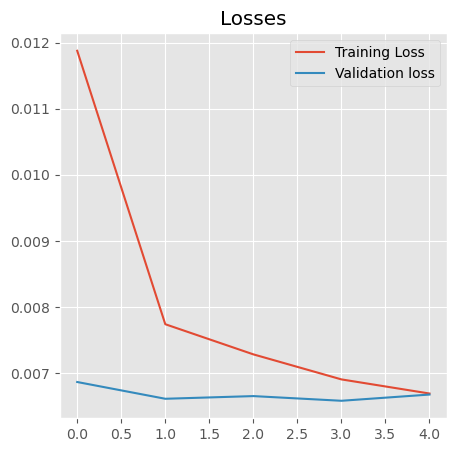

In [43]:
'''training the model'''
'''This model is flexible to change the number of hidden layers and number of neurons in the hidden layers also.
There is a fully connected layer and the number of neurons is given as one since we need a single prediction.
Based on the requirements, it can also be changed as well.
The data loader function can be used to'''
input_dim=x_train.shape[1]
output_dim=1
hidden_dim=64
layer_dim=1
batch_size=64
epochs=5
learning_rate=1e-3
weight_decay=1e-5
model=RNN(input_dim,hidden_dim,layer_dim,output_dim)
model.cuda() # when we are using the gpu through cuda,all the data,parameters and the model created should be 
#assigned to cuda by using this function call.
train_loader=dataloader(x_train_norm,y_train_norm,batch_size)
val_loader=dataloader(x_val_norm,y_val_norm,batch_size)
train_loss,validation_loss,r2_train,r2_val=training(model,learning_rate,epochs,weight_decay,
                                                batch_size,train_loader,val_loader)
plot_loss(train_loss,validation_loss)

In [44]:
def plot_r2score(r2_train,r2_val):
    plt.figure(figsize=(5,3))
    plt.plot(r2_train,label='R2-score(train)')
    plt.plot(r2_val,label='R2-score(validation)')
    plt.legend()
    plt.title('R2-SCORE')
    plt.show()
    plt.close()
        

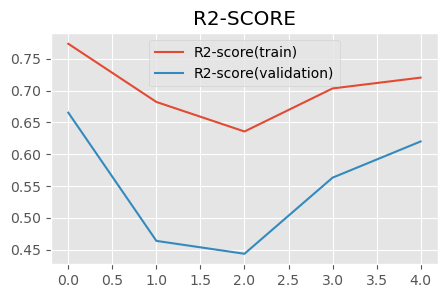

In [45]:
plot_r2score(r2_train,r2_val)

In [46]:
'''predictions on the test data using dataloader(not required,just for comparison)'''
test_loader=dataloader(x_test_norm,y_test_norm,batch_size=64)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
test_loss=[]
test_r2=[]
for x_test_batch,y_test_batch in test_loader:
    x_test_batch=x_test_batch.view(batch_size,-1,input_dim)
    x_test_batch=x_test_batch.to(device)
    y_test_batch=y_test_batch.to(device)
    model.eval()
    yhat_test=model(x_test_batch)
    testbatchloss=criterion(y_test_batch,yhat_test)
    test_loss.append(testbatchloss.item())
    r2score_test=r2_score(y_test_batch.detach().cpu().numpy(),yhat_test.detach().cpu().numpy())
    test_r2.append(r2score_test)
testing_loss=np.mean(test_loss)
test_r2=np.mean(test_r2)
print(f'The mean square error loss of given test data is {testing_loss}')
print(f'The R2-score of given test data is {test_r2}')
print(f'The root mean square error loss of given test data is {testing_loss**(1/2)}')
    

The mean square error loss of given test data is 0.006703029544010214
The R2-score of given test data is -25.32128601649195
The root mean square error loss of given test data is 0.08187203151266136


In [47]:
x_test_norm.shape

torch.Size([38764, 151])

In [48]:
'''prediction on test data taking the whole test data at once'''
x_test_norm=x_test_norm.to(device)
y_test_norm=y_test_norm.to(device)
x_test_norm=x_test_norm.view(x_test_norm.size(0),-1,input_dim)
model.eval()
yp=model(x_test_norm)
testloss=criterion(y_test_norm,yp)
r2s_test=r2_score(y_test_norm.detach().cpu().numpy(),yp.detach().cpu().numpy())
mean_abs=mean_absolute_error(y_test_norm.detach().cpu().numpy(),yp.detach().cpu().numpy())
print(f'The mean square error loss of given test data is {testloss}')
print(f'The R2-score of given test data is {r2s_test}')
print(f'The mean absolute error loss of given test data is {mean_abs}')
print(f'The root mean square error loss of given test data is {testloss**(1/2)}')

The mean square error loss of given test data is 0.0067011103965342045
The R2-score of given test data is 0.5565510340804146
The mean absolute error loss of given test data is 0.0442875511944294
The root mean square error loss of given test data is 0.08186031132936478


In [49]:
'''Below given the calculation of r2-score of test data after reverting the normalised data into original data'''
original_y_test = scaler.inverse_transform(y_test_norm.detach().cpu().numpy())
predicted_y_test=scaler.inverse_transform(yp.detach().cpu().numpy())
r2s_test_original=r2_score(original_y_test,predicted_y_test)
print(f'The R2-Score of un-normalised data is :{r2s_test_original}')

The R2-Score of un-normalised data is :0.55655101001691


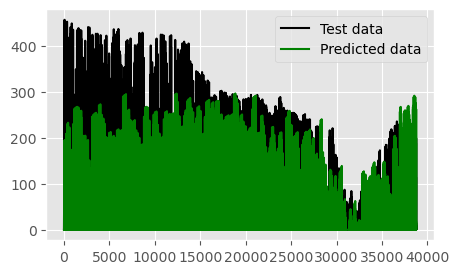

In [50]:
'''plotting the patterns of test and predicted data'''
plt.figure(figsize=(5,3))
plt.plot(original_y_test,label='Test data',color='black')
plt.plot(predicted_y_test,color='g',label='Predicted data')
plt.legend()
plt.show()

In [51]:
'''These are the actual and predicted values of test data'''
labels=np.concatenate((original_y_test,predicted_y_test),axis=1)
print(labels.shape)
labels=pd.DataFrame(labels)
labels=labels.rename(columns={0:'True',1:'Predicted'})
labels

(38764, 2)


,True,Predicted
0,1.444000,0.000000
1,7.057000,0.000000
2,13.790000,0.000000
3,0.486000,0.000000
4,23.900002,0.000000
...,...,...
38759,177.343994,236.340225
38760,8.382999,0.000000
38761,0.051000,91.404594
38762,7.683000,0.000000


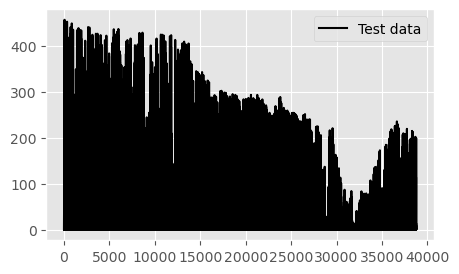

In [52]:
plt.figure(figsize=(5,3))
plt.plot(original_y_test,label='Test data',color='black')
#plt.plot(predicted_y_test,color='g',label='Predicted data')
plt.legend()
plt.show()

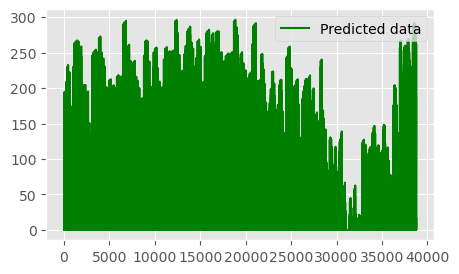

In [53]:
plt.figure(figsize=(5,3))
#plt.plot(original_y_test,label='Test data',color='black')
plt.plot(predicted_y_test,color='g',label='Predicted data')
plt.legend()
plt.show()

Here, a Recurrent neural network(RNN) is used to predict the solar power obtained.The data consists of various 
features such as insallationdate,power obtained(kwh),different solarpower panels, date and time of power mesurement etc.
So,from the data, various features have been extracted such as 'day_of-week','week_of_year,'month','date','hour' etc.
Also,cyclic features have been extracted using periodic functions of sine and cosine.After the data preprocessing, a total of
151 features have been obtained. So, in the vanilla RNN architecture used, there were 151 time steps where each feature is
given at each timestep. The training was done for different conditions and the best result obtained using this model is displayed.
The data was split into train,test and validation data in the ratio of 60%-20%-20% without shuffle. So, the predictions
was done on the last 20% data. The R2 score was found to be around 56%,which shows the goodness of the fit.

By using a better model such as LSTM,GRU,ATTENTION MODEL,TRANSFORMER etc, we can improve the results by a good margin. Also, we can extract more number of features as well to do the training.